# 准备工作

## import

In [7]:
from __future__ import division

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from terminaltables import AsciiTable

In [3]:
import os
import sys
import time
import datetime
import argparse

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [8]:
import numpy as np

In [9]:
#设置张量和模型存放位置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
#创建两个目录
os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)


## argparse()

In [8]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
    parser.add_argument("--batch_size", type=int, default=4, help="size of each image batch")
    parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
    parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
    parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")         #"config/coco.data"包含了训练集训练的信息
    parser.add_argument("--pretrained_weights", type=str, default="weights/darknet53.conv.74", help="if specified starts from checkpoint model")#"weights/darknet53.conv.74"包括了预训练权重参数
    parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
    parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
    parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
    parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
    parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
    parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
    #获取该参数对象的参数
    opt=parser.parse_known_args()[0]
    print(opt)

Namespace(batch_size=4, checkpoint_interval=1, compute_map=False, data_config='config/coco.data', epochs=100, evaluation_interval=1, gradient_accumulations=2, img_size=416, model_def='config/yolov3.cfg', multiscale_training=True, n_cpu=0, pretrained_weights='weights/darknet53.conv.74')


# 数据集信息的输入

### parse_data_config(path)

<font color='#ff590b'><font size=6.5> coco.data:

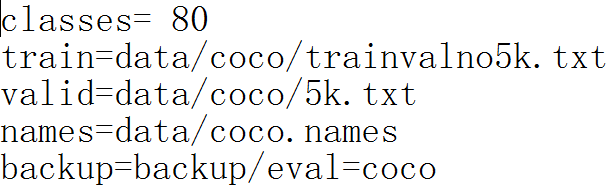

In [12]:
def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options

### load_classes(path)

<font color='#ff590b'><font size=6.5> data/coco.names:
    
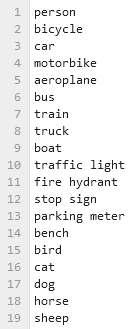

In [14]:
def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names

## <font color='#ff590b'><font size=6.5>  $\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla$

In [21]:
    data_config = parse_data_config(opt.data_config)      #data_config= "config/coco.data",包含了训练集训练的信息
    train_path = data_config["train"]                     #train_path = 'data/coco/trainvalno5k.txt'
    valid_path = data_config["valid"]                     #valid_path = 'data/coco/5k.txt'
    class_names = load_classes(data_config["names"])      #data_config["names"] = 'data/coco.names'

# 模型的搭建

### parse_model_config(path)

In [16]:
def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

### create_modules(module_defs)

In [17]:
def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route": # 输入1：26*26*256 输入2：26*26*128  输出：26*26*（256+128）
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list

### EmptyLayer(nn.Module):

In [18]:
class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()

### YOLOLayer(nn.Module)

In [19]:
class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):
        # Tensors for cuda support
        print (x.shape)
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)

        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )
        print (prediction.shape)
        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda) #相对位置得到对应的绝对位置比如之前的位置是0.5,0.5变为 11.5，11.5这样的

        # Add offset and scale with anchors #特征图中的实际位置
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat( 
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride, #还原到原始图中
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )
            # iou_scores：真实值与最匹配的anchor的IOU得分值 class_mask：分类正确的索引  obj_mask：目标框所在位置的最好anchor置为1 noobj_mask obj_mask那里置0，还有计算的iou大于阈值的也置0，其他都为1 tx, ty, tw, th, 对应的对于该大小的特征图的xywh目标值也就是我们需要拟合的值 tconf 目标置信度
            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask]) # 只计算有目标的
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask]) 
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj #有物体越接近1越好 没物体的越接近0越好
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask]) #分类损失
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls #总损失

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss

### Upsample(nn.Module)

In [20]:
class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

### Darknet(nn.Module)

In [21]:
class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        #parse_model_config()是定义在utils.parse_config中的函数，用于读取txt中的模型信息
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()

### weights_init_normal(m)

In [22]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## <font color='#ff590b'><font size=6.5>  $\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla$

In [45]:
    #参数model_df定义了config/yolov3.cfg模型的存放的位置，Darknet会根据文件生成相应的网络模型
    model = Darknet(opt.model_def).to(device)     #opt.model_def="config/yolov3.cfg"
    #weights_init_normal是定义在utils.utils中的函数，用于对模型的参数初始化
    model.apply(weights_init_normal)

    # 读取预训练权重
    if opt.pretrained_weights:
        if opt.pretrained_weights.endswith(".pth"):
            model.load_state_dict(torch.load(opt.pretrained_weights))
        else:
            model.load_darknet_weights(opt.pretrained_weights)

# 数据集加载(Dataloader)

### ListDataset(Dataset)(文件位置设置)

In [23]:
from torch.utils.data import Dataset

In [24]:
class ListDataset(Dataset):
    def __init__(self, list_path, img_size=416, augment=True, multiscale=True, normalized_labels=True):
        with open(list_path, "r") as file:
            self.img_files = file.readlines()
        #将label与对应的图片对应上
        self.label_files = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.img_files
        ]
        self.img_size = img_size
        self.max_objects = 100
        self.augment = augment
        self.multiscale = multiscale
        self.normalized_labels = normalized_labels
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0

    def __getitem__(self, index):

        # ---------
        #  Image
        # ---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()
        img_path = r'F:\我的个人文件\我的文档\工作文件夹\Windows端\0.资料\第六章 第四模块：综合项目-物体检测YOLO实战\PyTorch-YOLOv3\data\coco' + img_path
        #print (img_path)
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path).convert('RGB'))

        # Handle images with less than three channels
        if len(img.shape) != 3:
            img = img.unsqueeze(0)
            img = img.expand((3, img.shape[1:]))

        _, h, w = img.shape
        h_factor, w_factor = (h, w) if self.normalized_labels else (1, 1)
        # Pad to square resolution
        img, pad = pad_to_square(img, 0)
        _, padded_h, padded_w = img.shape

        # ---------
        #  Label
        # ---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()
        label_path = r'F:\\我的个人文件\\我的文档\\工作文件夹\\Windows端\\0.资料\\第六章 第四模块：综合项目-物体检测YOLO实战\\PyTorch-YOLOv3\\data\\coco\\labels' + label_path
        #print (label_path)

        targets = None
        if os.path.exists(label_path):
            boxes = torch.from_numpy(np.loadtxt(label_path).reshape(-1, 5))
            # Extract coordinates for unpadded + unscaled image
            x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
            y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
            x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
            y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
            # Adjust for added padding
            x1 += pad[0]
            y1 += pad[2]
            x2 += pad[1]
            y2 += pad[3]
            # Returns (x, y, w, h)
            boxes[:, 1] = ((x1 + x2) / 2) / padded_w
            boxes[:, 2] = ((y1 + y2) / 2) / padded_h
            boxes[:, 3] *= w_factor / padded_w
            boxes[:, 4] *= h_factor / padded_h

            targets = torch.zeros((len(boxes), 6))
            targets[:, 1:] = boxes

        # Apply augmentations
        if self.augment:
            if np.random.random() < 0.5:
                img, targets = horisontal_flip(img, targets)

        return img_path, img, targets

    def collate_fn(self, batch):
        paths, imgs, targets = list(zip(*batch))
        # Remove empty placeholder targets
        targets = [boxes for boxes in targets if boxes is not None]
        # Add sample index to targets
        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
        self.batch_count += 1
        return paths, imgs, targets

    def __len__(self):
        return len(self.img_files)

## <font color='#ff590b'><font size=6.5>  $\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla$

In [60]:
    # ListDataset是定义在datasets中的一个类，用于加载训练集并将label与图片进行一一对应。
    dataset = ListDataset(train_path, augment=True, multiscale=opt.multiscale_training)
    #进行数据集的加载，dataset是一个类，类中包含数据集，以及3个方法，用于给dataloader打包数据集。
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=opt.batch_size,
        shuffle=True,
        num_workers=opt.n_cpu,
        pin_memory=True,
        collate_fn=dataset.collate_fn,
    )

# 训练

## pad_to_square(img, pad_value)

In [25]:
def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad

## horisontal_flip(images, targets)

In [26]:
def horisontal_flip(images, targets):
    images = torch.flip(images, [-1])
    targets[:, 2] = 1 - targets[:, 2]
    return images, targets

## resize(image, size)

In [27]:
def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

## build_targets()

In [28]:
def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0) # batchsieze 4
    nA = pred_boxes.size(1) # 每个格子对应了多少个anchor
    nC = pred_cls.size(-1)  # 类别的数量
    nG = pred_boxes.size(2) # gridsize

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)  # obj，anchor包含物体, 即为1，默认为0 考虑前景
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1) # noobj, anchor不包含物体, 则为1，默认为1 考虑背景
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0) # 类别掩膜，类别预测正确即为1，默认全为0
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0) # 预测框与真实框的iou得分
    tx = FloatTensor(nB, nA, nG, nG).fill_(0) # 真实框相对于网格的位置
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0) 
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG #target中的xywh都是0-1的，可以得到其在当前gridsize上的xywh
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors]) #每一种规格的anchor跟每个标签上的框的IOU得分
    print (ious.shape)
    best_ious, best_n = ious.max(0) # 得到其最高分以及哪种规格框和当前目标最相似
    # Separate target values
    b, target_labels = target[:, :2].long().t() # 真实框所对应的batch，以及每个框所代表的实际类别
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t() #位置信息，向下取整了
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1 # 实际包含物体的设置成1
    noobj_mask[b, best_n, gj, gi] = 0 # 相反

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()): # IOU超过了指定的阈值就相当于有物体了
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor() # 根据真实框所在位置，得到其相当于网络的位置
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1 #将真实框的标签转换为one-hot编码形式
    # Compute label correctness and iou at best anchor 计算预测的和真实一样的索引
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False) #与真实框想匹配的预测框之间的iou值

    tconf = obj_mask.float() # 真实框的置信度，也就是1
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

## bbox_wh_iou(wh1, wh2)

In [29]:
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

## bbox_iou(box1, box2, x1y1x2y2=True)

In [30]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

## to_cpu(tensor)

In [31]:
def to_cpu(tensor):
    return tensor.detach().cpu()

## Logger(object)

In [32]:
import tensorflow as tf

class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step)
            self.writer.flush()
    def list_of_scalars_summary(self, tag_value_pairs, step):
        with self.writer.as_default():
            for tag, value in tag_value_pairs:
                tf.summary.scalar(tag, value, step=step)
            self.writer.flush()
        # summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value) for tag, value in tag_value_pairs])
        # self.writer.add_summary(summary, step)

In [33]:
logger = Logger("logs")

## <font color='#ff590b'><font size=6.5>  $\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla$

In [44]:
from PIL import Image
import random

In [ ]:
    optimizer = torch.optim.Adam(model.parameters())
    metrics = ["grid_size","loss","x","y","w","h","conf","cls","cls_acc","recall50","recall75","precision","conf_obj","conf_noobj",]

    for epoch in range(opt.epochs):
        model.train()
        start_time = time.time()
        for batch_i, (_, imgs, targets) in enumerate(dataloader):
            batches_done = len(dataloader) * epoch + batch_i

            imgs = Variable(imgs.to(device))
            targets = Variable(targets.to(device), requires_grad=False)
            print ('imgs',imgs.shape)
            print ('targets',targets.shape)
            loss, outputs = model(imgs, targets)
            loss.backward()

            if batches_done % opt.gradient_accumulations:
                # Accumulates gradient before each step
                optimizer.step()
                optimizer.zero_grad()

            # ----------------
            #   Log progress
            # ----------------

            log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, opt.epochs, batch_i, len(dataloader))

            metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

            # Log metrics at each YOLO layer
            for i, metric in enumerate(metrics):
                formats = {m: "%.6f" for m in metrics}
                formats["grid_size"] = "%2d"
                formats["cls_acc"] = "%.2f%%"
                row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
                metric_table += [[metric, *row_metrics]]

                # Tensorboard logging
                tensorboard_log = []
                for j, yolo in enumerate(model.yolo_layers):
                    for name, metric in yolo.metrics.items():
                        if name != "grid_size":
                            tensorboard_log += [(f"{name}_{j+1}", metric)]
                tensorboard_log += [("loss", loss.item())]
                logger.list_of_scalars_summary(tensorboard_log, batches_done)

            log_str += AsciiTable(metric_table).table
            log_str += f"\nTotal loss {loss.item()}"

            # Determine approximate time left for epoch
            epoch_batches_left = len(dataloader) - (batch_i + 1)
            time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
            log_str += f"\n---- ETA {time_left}"

            print(log_str)

            model.seen += imgs.size(0)

        if epoch % opt.evaluation_interval == 0:
            print("\n---- Evaluating Model ----")
            # Evaluate the model on the validation set
            precision, recall, AP, f1, ap_class = evaluate(
                model,
                path=valid_path,
                iou_thres=0.5,
                conf_thres=0.5,
                nms_thres=0.5,
                img_size=opt.img_size,
                batch_size=8,
            )
            evaluation_metrics = [
                ("val_precision", precision.mean()),
                ("val_recall", recall.mean()),
                ("val_mAP", AP.mean()),
                ("val_f1", f1.mean()),
            ]
            logger.list_of_scalars_summary(evaluation_metrics, epoch)

            # Print class APs and mAP
            ap_table = [["Index", "Class name", "AP"]]
            for i, c in enumerate(ap_class):
                ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
            print(AsciiTable(ap_table).table)
            print(f"---- mAP {AP.mean()}")

        if epoch % opt.checkpoint_interval == 0:
            torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)

# 测试

## evaluate()

In [10]:
def evaluate(model, path, iou_thres, conf_thres, nms_thres, img_size, batch_size):
    model.eval()

    # Get dataloader
    dataset = ListDataset(path, img_size=img_size, augment=False, multiscale=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=dataset.collate_fn
    )

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm(dataloader, desc="Detecting objects")):

        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class

## <font color='#ff590b'><font size=6.5>  $\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla$

In [35]:
import tqdm

In [36]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
    parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
    parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
    parser.add_argument("--weights_path", type=str, default="weights/yolov3.weights", help="path to weights file")
    parser.add_argument("--class_path", type=str, default="data/coco.names", help="path to class label file")
    parser.add_argument("--iou_thres", type=float, default=0.5, help="iou threshold required to qualify as detected")
    parser.add_argument("--conf_thres", type=float, default=0.001, help="object confidence threshold")
    parser.add_argument("--nms_thres", type=float, default=0.5, help="iou thresshold for non-maximum suppression")
    parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
    parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
    opt=parser.parse_known_args()[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_config = parse_data_config(opt.data_config)
    valid_path = data_config["valid"]
    class_names = load_classes(data_config["names"])

    # Initiate model
    model = Darknet(opt.model_def).to(device)
    if opt.weights_path.endswith(".weights"):
        # Load darknet weights
        model.load_darknet_weights(opt.weights_path)
    else:
        # Load checkpoint weights
        model.load_state_dict(torch.load(opt.weights_path))

    print("Compute mAP...")

    precision, recall, AP, f1, ap_class = evaluate(
        model,
        path=valid_path,
        iou_thres=opt.iou_thres,
        conf_thres=opt.conf_thres,
        nms_thres=opt.nms_thres,
        img_size=opt.img_size,
        batch_size=8,
    )

    print("Average Precisions:")
    for i, c in enumerate(ap_class):
        print(f"+ Class '{c}' ({class_names[c]}) - AP: {AP[i]}")

    print(f"mAP: {AP.mean()}")

Detecting objects:   0%|                               | 0/625 [00:00<?, ?it/s]

Compute mAP...


Detecting objects:   0%|                               | 0/625 [00:01<?, ?it/s]


BrokenPipeError: [Errno 32] Broken pipe

# 开始检测

## ImageFolder(Dataset)

In [41]:
import glob

In [42]:
class ImageFolder(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.img_size = img_size

    def __getitem__(self, index):
        img_path = self.files[index % len(self.files)]
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path))
        # Pad to square resolution
        img, _ = pad_to_square(img, 0)
        # Resize
        img = resize(img, self.img_size)

        return img_path, img

    def __len__(self):
        return len(self.files)

## non_max_suppression()

In [47]:
def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output

## xywh2xyxy(x)

In [49]:
def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

## rescale_boxes()

In [53]:
def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes

## <font color='#ff590b'><font size=6.5>  $\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla\nabla$

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


Performing object detection:
torch.Size([1, 255, 13, 13])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 255, 26, 26])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 255, 52, 52])
torch.Size([1, 3, 52, 52, 85])
	+ Batch 0, Inference Time: 0:00:03.530005
torch.Size([1, 255, 13, 13])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 255, 26, 26])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 255, 52, 52])
torch.Size([1, 3, 52, 52, 85])
	+ Batch 1, Inference Time: 0:00:03.582008
torch.Size([1, 255, 13, 13])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 255, 26, 26])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 255, 52, 52])
torch.Size([1, 3, 52, 52, 85])
	+ Batch 2, Inference Time: 0:00:03.622007
torch.Size([1, 255, 13, 13])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 255, 26, 26])
torch.Size([1, 3, 26, 26, 85])
torch.Size([1, 255, 52, 52])
torch.Size([1, 3, 52, 52, 85])
	+ Batch 3, Inference Time: 0:00:03.560005
torch.Size([1, 255, 13, 13])
torch.Size([1, 3, 13, 13, 85])
torch.Size([1, 255

<Figure size 432x288 with 0 Axes>

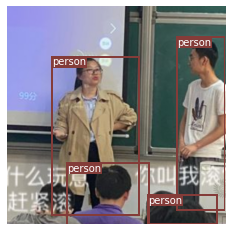

(1) Image: 'data/samples\eagle.jpg'
	+ Label: bird, Conf: 0.99703


<Figure size 432x288 with 0 Axes>

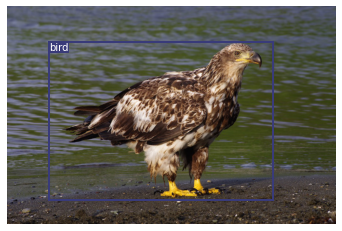

(2) Image: 'data/samples\field.jpg'
	+ Label: person, Conf: 0.99996
	+ Label: horse, Conf: 0.99977
	+ Label: dog, Conf: 0.99409


<Figure size 432x288 with 0 Axes>

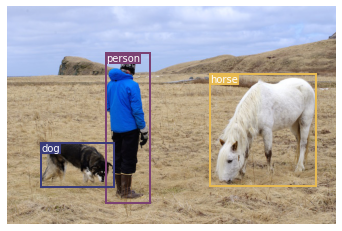

(3) Image: 'data/samples\giraffe.jpg'
	+ Label: giraffe, Conf: 0.99959
	+ Label: zebra, Conf: 0.97958


<Figure size 432x288 with 0 Axes>

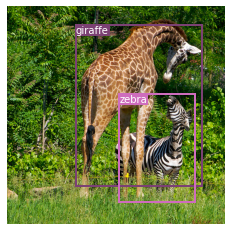

(4) Image: 'data/samples\herd_of_horses.jpg'
	+ Label: horse, Conf: 0.99459
	+ Label: horse, Conf: 0.99352
	+ Label: horse, Conf: 0.96845
	+ Label: horse, Conf: 0.99478


<Figure size 432x288 with 0 Axes>

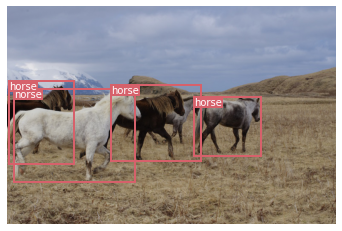

(5) Image: 'data/samples\messi.jpg'
	+ Label: person, Conf: 0.99993
	+ Label: person, Conf: 0.99984
	+ Label: person, Conf: 0.99996


<Figure size 432x288 with 0 Axes>

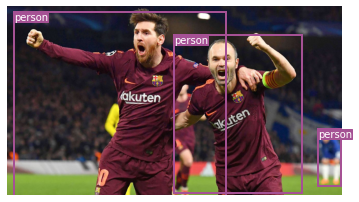

(6) Image: 'data/samples\person.jpg'
	+ Label: person, Conf: 0.99991
	+ Label: person, Conf: 0.99995
	+ Label: tie, Conf: 0.99973
	+ Label: person, Conf: 0.99992
	+ Label: person, Conf: 0.99995
	+ Label: person, Conf: 0.99977
	+ Label: person, Conf: 0.99995
	+ Label: person, Conf: 0.99998
	+ Label: person, Conf: 0.99990


<Figure size 432x288 with 0 Axes>

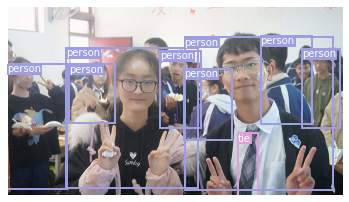

(7) Image: 'data/samples\room.jpg'
	+ Label: chair, Conf: 0.99906
	+ Label: chair, Conf: 0.96942
	+ Label: clock, Conf: 0.99971


<Figure size 432x288 with 0 Axes>

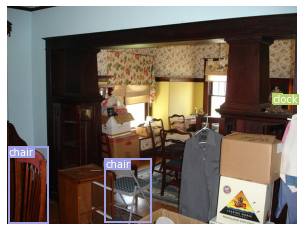

(8) Image: 'data/samples\street.jpg'
	+ Label: car, Conf: 0.99977
	+ Label: car, Conf: 0.99402
	+ Label: car, Conf: 0.99841
	+ Label: car, Conf: 0.99785
	+ Label: car, Conf: 0.97907
	+ Label: car, Conf: 0.95370
	+ Label: traffic light, Conf: 0.99995
	+ Label: car, Conf: 0.62254


<Figure size 432x288 with 0 Axes>

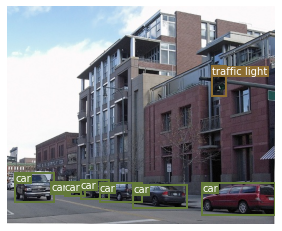

In [57]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--image_folder", type=str, default="data/samples", help="path to dataset")
    parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
    parser.add_argument("--weights_path", type=str, default="weights/yolov3.weights", help="path to weights file")
    parser.add_argument("--class_path", type=str, default="data/coco.names", help="path to class label file")
    parser.add_argument("--conf_thres", type=float, default=0.8, help="object confidence threshold")
    parser.add_argument("--nms_thres", type=float, default=0.4, help="iou thresshold for non-maximum suppression")
    parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
    parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
    parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
    parser.add_argument("--checkpoint_model", type=str, help="path to checkpoint model")
    opt=parser.parse_known_args()[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs("output", exist_ok=True)

    # Set up model
    model = Darknet(opt.model_def, img_size=opt.img_size).to(device)

    if opt.weights_path.endswith(".weights"):
        # Load darknet weights
        model.load_darknet_weights(opt.weights_path)
    else:
        # Load checkpoint weights
        model.load_state_dict(torch.load(opt.weights_path))

    model.eval()  # Set in evaluation mode

    dataloader = DataLoader(
        ImageFolder(opt.image_folder, img_size=opt.img_size),
        batch_size=opt.batch_size,
        shuffle=False,
        num_workers=opt.n_cpu,
    )

    classes = load_classes(opt.class_path)  # Extracts class labels from file

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    imgs = []  # Stores image paths
    img_detections = []  # Stores detections for each image index

    print("\nPerforming object detection:")
    prev_time = time.time()
    for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        # Configure input
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)

        # Log progress
        current_time = time.time()
        inference_time = datetime.timedelta(seconds=current_time - prev_time)
        prev_time = current_time
        print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

        # Save image and detections
        imgs.extend(img_paths)
        img_detections.extend(detections)

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    print("\nSaving images:")
    # Iterate through images and save plot of detections
    for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

        print("(%d) Image: '%s'" % (img_i, path))

        # Create plot
        img = np.array(Image.open(path))
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to original image
            detections = rescale_boxes(detections, opt.img_size, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=classes[int(cls_pred)],
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        # Save generated image with detections
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        filename = path.split("/")[-1].split(".")[0]
        plt.savefig(f"output/{filename}.png", bbox_inches="tight", pad_inches=0.0)
        plt.show()
        plt.close()